In [57]:
from __future__ import print_function, division
import sys
import copy
import os
import datetime
import time
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.nn as nn
import torch
import os
from src.shared import data_split, should_print
from randaugment import RandAugment

plt.ion()   # interactive mode

In [11]:
# for compatibility with old code
is_local = True
BATCH_SIZE = 32

In [63]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        RandAugment(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset_name = "CUB_200"
# dataset_name = "CUB_200_2011/CUB_200_2011/images"
data_dir = f"datasets/{dataset_name}" if is_local else f"/users/tjiang12/data/tjiang12/{dataset_name}"
dataset = datasets.ImageFolder(data_dir, data_transforms['train'])

image_datasets, test_set = data_split(dataset)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [classname.split('.')[1].replace('_', ' ') for classname in dataset.classes]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
# path of weights transfered from CCV
PATH = "weights/NoisyStudent"
# PATH = "weights/resnet50_CUB200_66pct"
model_loaded = models.resnet50()
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = nn.Linear(num_ftrs, len(class_names))

model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [60]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                pred_status = "✔" if preds[j] == labels[j] else "✘, " + class_names[labels[j]]
                ax.set_title('{} ({})'.format(class_names[preds[j]], pred_status))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

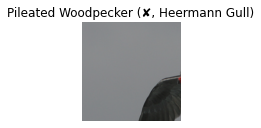

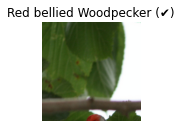

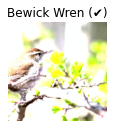

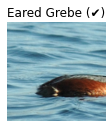

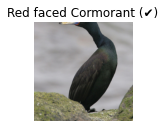

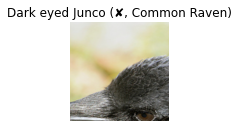

In [66]:
visualize_model(model_loaded)

In [50]:
def evaluate_model(model, test_set):
    model.eval()
    loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)
    print('Test set size:', len(test_set))
    with torch.no_grad():
        running_corrects = 0
        seen = 0
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            seen += len(inputs)
            print(preds)
            print(labels)
            print(int(running_corrects), "/", seen, running_corrects / seen)
    return running_corrects / seen

In [55]:
evaluate_model(model_loaded, test_set)

Test set size: 1206
tensor([ 60, 188,  32,  50,  23,  18,  83, 127,  98,  89,  92,   3, 117,  76,
         34,  13, 164,  65, 105,   0, 109, 191,  13, 118, 197,  78, 104, 106,
         73, 188,  19,  14])
tensor([ 60, 188, 192,  49,  23, 106,  83,   9,  98,  89, 111,   3, 117,  76,
         34,  13, 164,  61, 105,   0, 158, 191,  13, 171, 192,  78, 104, 106,
         73, 188, 160,  14])
22 / 32 tensor(0.6875)
tensor([135, 184, 144,  45,   6,  78,  45, 187,  61, 100, 198,  40, 132,  36,
         59,  32,  80, 140,  45,  39, 169,  28,  88, 142, 110,  70,   5, 109,
         27, 174, 190, 153])
tensor([135, 184, 144,  45,   6, 198,  45, 187,  59, 100, 198,  40, 132,  36,
         57,  77,  71, 143,  45,  39, 169,   3,  45, 142, 110,  73,   5, 109,
         27, 174, 190, 180])
44 / 64 tensor(0.6875)
tensor([ 14, 114,  92, 163, 111, 149, 127, 146,  85,  96,  73, 104,  88,  26,
        118, 139, 100,   7, 172,  38,  82,  42, 186,  95,  37, 197,  92, 160,
        108, 120,  36,  38])
tensor([1

tensor([103,  86, 108, 179,  87,  19, 198, 161, 138,   6, 187, 194, 110,  75,
         48,  20, 182,  52,  93,  60, 189,  43, 163, 138, 175,  12,  97, 150,
        155, 111, 150,  33])
tensor([103,  45,  20, 179,  87,  19, 199, 161,  41,   5, 187, 194, 110,  75,
         48,  20, 182,  52,  93,  60, 103,  43, 163,  16, 175, 190,  97, 150,
        155, 111, 150,  33])
551 / 704 tensor(0.7827)
tensor([125, 162,  91, 121,   2, 192, 128,  16,  52,  30,   7, 126, 182,  23,
         27, 189, 126,  51, 144,  30, 113, 146,  18,   8, 150,  93,  54,  88,
        126,  13,  90,  34])
tensor([125, 162,  91, 121,   2, 192, 128,  16,  52,  30,   7, 126, 183,  89,
        135, 189, 126, 105, 144,  30, 113, 146, 195,  12, 150,  93,  54,  88,
        126,  13,  90,  34])
577 / 736 tensor(0.7840)
tensor([194,  28,  38,  18, 175, 197,  77,  96,  60,  30,  98,  92, 174,  65,
         42,  29, 132, 194, 194,  49, 146, 140, 131,  67,  57,  96,  32, 133,
         50, 143, 140, 168])
tensor([194,  28, 102, 11

tensor(0.7753)